In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
rcParams['figure.figsize'] = (16, 10)
rcParams["savefig.format"] = 'png'

In [3]:
# !pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
# import pyfolio

In [4]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [5]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [6]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    print(df_account_value.head())
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    #df_account_value=df_account_value.join(df_trade_date.reset_index(drop=True))
    return df_account_value

In [7]:
df_btc=pd.read_csv('done_data.csv')
df_btc=df_btc[(df_btc.datadate >= 20190101) & (df_btc.tic=='ETH')]
df_btc['daily_return']=df_btc['adjcp'].pct_change(1)
df_btc['Date'] = pd.to_datetime(df_btc['datadate'],format='%Y%m%d').dt.date

In [8]:
df_btc.shape

(278, 18)

In [9]:
df_btc.head()

,Unnamed: 0,datadate,tic,adjcp,open,high,low,volume,neutral,positive,negative,macd,rsi,cci,adx,turbulence,daily_return,Date
2291,2291,20190219,ETH,145.346184,146.398820,149.929978,145.128467,5310842625,77.347001,3.599612,0.053387,6.701315,51.840747,143.848915,36.359070,0.505861,NaN,2019-02-19
2293,2293,20190220,ETH,149.554344,145.172723,149.554344,142.502127,4500094965,77.323183,6.659549,0.017268,7.784428,52.883314,131.129732,32.256889,0.495939,0.028953,2019-02-20
2295,2295,20190221,ETH,146.130844,149.352327,149.352327,144.563818,3995766856,78.946282,8.021995,2.031723,8.271210,51.937070,117.023591,32.256889,0.500692,-0.022891,2019-02-21
2297,2297,20190222,ETH,149.092454,146.073257,149.268617,145.206541,3731099284,79.976224,4.379713,0.644062,8.794587,52.694559,110.285304,32.256889,0.504257,0.020267,2019-02-22
2299,2299,20190223,ETH,158.795430,148.676622,159.125870,147.331060,4519468458,84.462955,8.281207,0.255839,9.878444,55.093268,121.803131,40.467591,0.495582,0.065080,2019-02-23


## Strategy : account value calculation

In [10]:
rebalance_window = 63
validation_window = 63

unique_trade_date = df_btc.datadate.unique()

In [11]:
len(unique_trade_date)

278

In [12]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [16]:
ti_ss_account_value = get_account_value('ensemble')
ti_ss_account_value = ti_ss_account_value.join(df_trade_date)
ti_ss_account_value = get_daily_return(ti_ss_account_value)
ti_ss_account_value['Date'] = pd.to_datetime(ti_ss_account_value['datadate'],format='%Y%m%d')#.dt.date
ti_ss_account_value.index = ensemble_account_value.Date
ti_ss_account_value.rename(columns={'account_value':'technical_indicator+sentiment_score','daily_return':'daily_return_ti+ss'}, inplace=True)

    account_value
0  1000000.000000
1   998811.390629
2   993440.728230
3   995508.688659
4   995095.559591
1.6950547244320922
Sharpe:  1.6950547244320922


In [17]:
ti_ss_account_value.head()

,technical_indicator+sentiment_score,datadate,daily_return_ti+ss,Date
Date,,,,
2019-02-19,1000000.000000,20190219,NaN,2019-02-19
2019-02-20,998811.390629,20190220,-0.001189,2019-02-20
2019-02-21,993440.728230,20190221,-0.005377,2019-02-21
2019-02-22,995508.688659,20190222,0.002082,2019-02-22
2019-02-23,995095.559591,20190223,-0.000415,2019-02-23


In [18]:
# ti_ss_account_value.to_csv('data/account_value_technical_indicator_sentiment_score.csv')

## Benchmark

In [19]:
benchmark = pd.read_csv('data/benchmark2019.csv', index_col=0)
benchmark.rename(columns={'account_value':'technical_indicator','daily_return':'daily_return_ti'}, inplace=True)
benchmark.drop('Date.1',axis=1,inplace=True)

In [20]:
benchmark.head()

,technical_indicator,datadate,daily_return_ti
Date,,,
2019-02-19,1000000.000000,20190219,NaN
2019-02-20,998811.390629,20190220,-0.001189
2019-02-21,993440.728230,20190221,-0.005377
2019-02-22,995508.688659,20190222,0.002082
2019-02-23,995095.559591,20190223,-0.000415


In [21]:
combined1 = benchmark.join(ti_ss_account_value[['technical_indicator+sentiment_score','daily_return_ti+ss']]).drop('datadate',axis=1)

In [22]:
combined1.head()

,technical_indicator,daily_return_ti,technical_indicator+sentiment_score,daily_return_ti+ss
Date,,,,
2019-02-19,1000000.000000,NaN,1000000.000000,NaN
2019-02-20,998811.390629,-0.001189,998811.390629,-0.001189
2019-02-21,993440.728230,-0.005377,993440.728230,-0.005377
2019-02-22,995508.688659,0.002082,995508.688659,0.002082
2019-02-23,995095.559591,-0.000415,995095.559591,-0.000415


In [23]:
# combined1.to_csv('data/account_value_comparison.csv')

## Plot

### Technical indicator vs Technical indicator + sentiment score

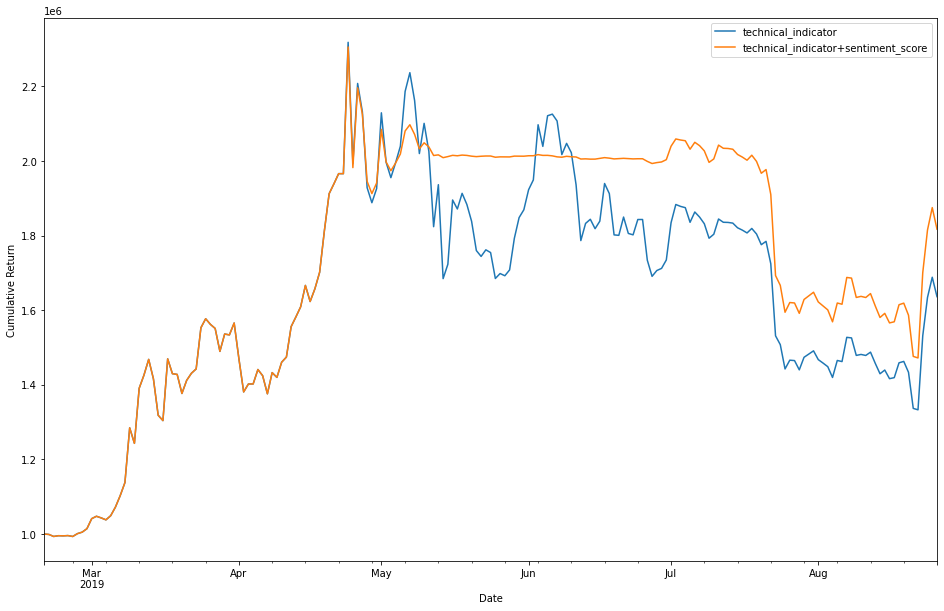

In [24]:
ax = combined1[['technical_indicator', 'technical_indicator+sentiment_score']].plot()
ax.set_ylabel("Cumulative Return")
plt.savefig('figs/performance.png', dpi=800, bbox_inches='tight')
#plt.close()

### Technical indicator + sentiment score vs Technical indicator + sentiment score + rnn score

In [28]:
ti_ss_rnn = pd.read_csv('data/account_value_technical_indicator_sentiment_rnn_score.csv', index_col=0)
ti_ss_rnn.drop('Date.1',axis=1,inplace=True)

In [29]:
ti_ss_rnn.head()

,technical_indicator+sentiment_score+rnn_score,datadate,daily_return_ti+ss+rnn_score
Date,,,
2019-02-19,1000000.000000,20190219,NaN
2019-02-20,998811.390629,20190220,-0.001189
2019-02-21,993440.728230,20190221,-0.005377
2019-02-22,995508.688659,20190222,0.002082
2019-02-23,995095.559591,20190223,-0.000415


In [35]:
combined2 = ti_ss_account_value[['technical_indicator+sentiment_score','daily_return_ti+ss']].join(ti_ss_rnn).drop('datadate',axis=1)

In [37]:
# combined2.to_csv('data/account_value_comparison2.csv')

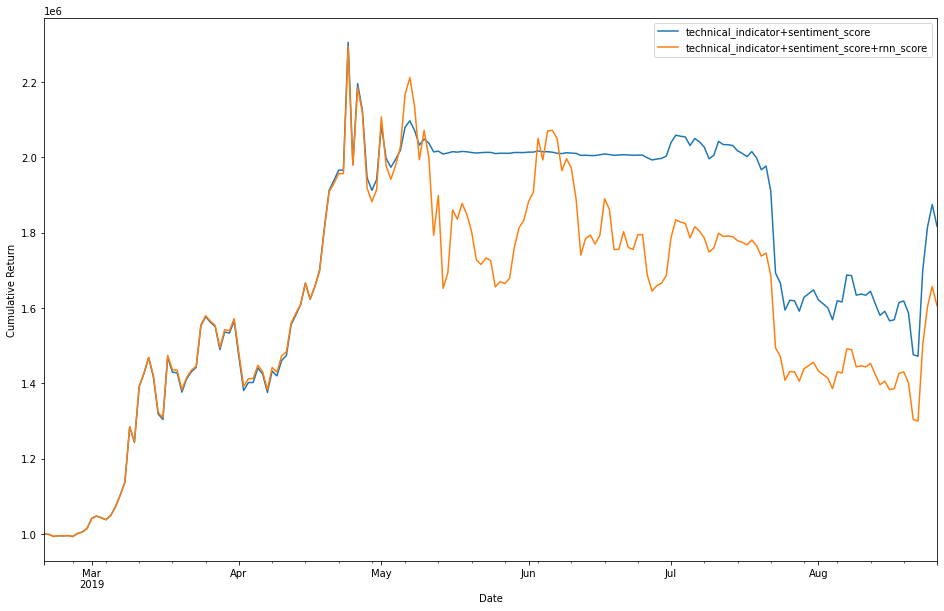

In [36]:
ax = combined2[['technical_indicator+sentiment_score', 'technical_indicator+sentiment_score+rnn_score']].plot()
ax.set_ylabel("Cumulative Return")
plt.savefig('figs/performance_new.png', dpi=800, bbox_inches='tight')
#plt.close()